In [54]:
%cd ../

/home/uky/repos_python


In [55]:
import os
import time
import argparse
import random
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

from baselines.models.diffusion import QFlow, DiffusionModel
from baselines.functions.test_function import TestFunction
from baselines.models.value_functions import ProxyEnsemble
from baselines.utils import set_seed
import wandb

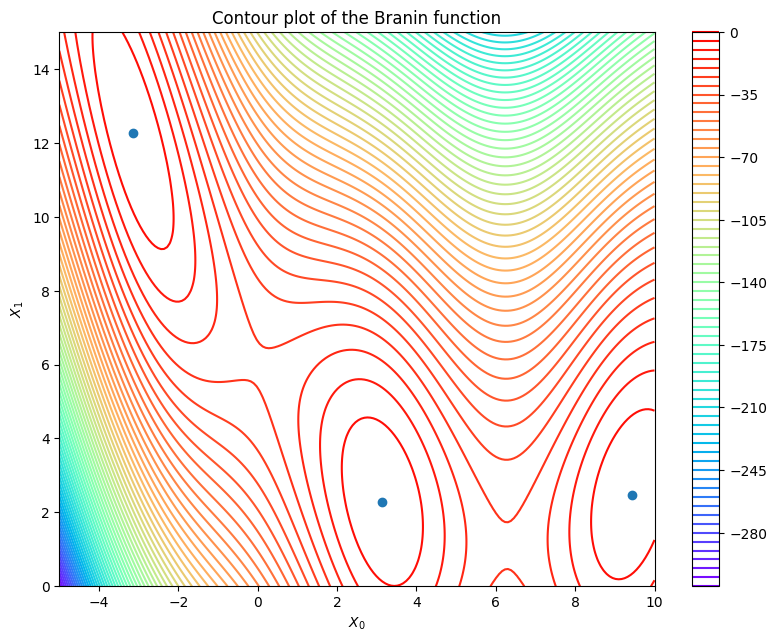

In [56]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from botorch.test_functions import Branin


# Define the Branin function using botorch
branin = Branin()
# Generate a meshgrid for the input space
x = np.linspace(-5, 10, 200)
y = np.linspace(0, 15, 200)
X, Y = np.meshgrid(x, y)

# Evaluate the Branin function on the meshgrid
Z = np.array([[branin(torch.from_numpy(np.array([X[i, j], Y[i, j]]))) for j in range(X.shape[1])] for i in range(X.shape[0])])
optima = np.array([[-np.pi, 12.275], [np.pi, 2.275], [9.42478, 2.475],])

plt.figure(figsize=(9.6, 7.2))
cp = plt.contour(X, Y, -Z, levels=75, cmap="rainbow")
plt.colorbar(cp)
plt.scatter(optima[:, 0], optima[:, 1], marker='o')
plt.title('Contour plot of the Branin function')
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()


In [57]:
class Args:
    pass

args = Args()
args.task = "Branin"
args.dim = 2
args.train_batch_size = 256
args.batch_size = 100
args.n_init = 100
args.seed = 42
args.max_evals = 10000
args.num_proxy_epochs = 100
args.num_prior_epochs = 100
args.num_posterior_epochs = 100
args.buffer_size = 1000
args.alpha = 0.0001
args.beta = 1.0
args.local_search = False
args.local_search_epochs = 10
args.diffusion_steps = 30
args.proxy_hidden_dim = 256

In [58]:
task = args.task
dim = args.dim
train_batch_size = args.train_batch_size
batch_size = args.batch_size
n_init = args.n_init
seed = args.seed
eval_size = 200
dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
set_seed(seed)

In [60]:
def get_initial_samples(n_init, seed):
    dim = 2
    bounds = [(-5.0, 10.0), (0.0, 15.0)]
    X_total = []
    y_total = []
    for i in range(5):
        X = np.random.rand(n_init, dim)
        for i in range(dim):
            X[:, i] = X[:, i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
        X = torch.tensor(X, dtype=dtype, device=device)
        y = torch.tensor([branin(x) for x in X], dtype=dtype, device=device)
        X_total.append(X)
        y_total.append(y)
    X = torch.cat(X_total, dim=0)
    y = torch.cat(y_total, dim=0)
    y = -y
    y_idx = y.argsort()
    X = X[y_idx]
    y = y[y_idx]
    X = X[:n_init]
    y = y[:n_init]
    # only low y samples return
    return X, y.unsqueeze(1)

X_init, y_init = get_initial_samples(eval_size, seed)    
X_init_numpy = X_init.cpu().numpy()
y_init_numpy = y_init.cpu().numpy()
print(X_init.shape, y_init.shape)

torch.Size([200, 2]) torch.Size([200, 1])


In [61]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from botorch.test_functions import Branin


# Define the Branin function using botorch
branin = Branin(negate=False)
# Generate a meshgrid for the input space
x = np.linspace(-5, 10, 200)
y = np.linspace(0, 15, 200)
X, Y = np.meshgrid(x, y)

# Evaluate the Branin function on the meshgrid
Z = np.array([[branin(torch.from_numpy(np.array([X[i, j], Y[i, j]]))) for j in range(X.shape[1])] for i in range(X.shape[0])])
optima = np.array([[-np.pi, 12.275], [np.pi, 2.275], [9.42478, 2.475],])

plt.figure(figsize=(9.6, 7.2))
cp = plt.contour(X, Y, -Z, levels=75, cmap="rainbow")
plt.colorbar(cp)
#plot init_data
plt.scatter(X_init_numpy[:, 0], X_init_numpy[:, 1], marker='x')
plt.scatter(optima[:, 0], optima[:, 1], marker='o')
plt.title('Contour plot of the Branin function')
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()


In [62]:
X_mean = X_init.mean(dim=0)
X_std = X_init.std(dim=0)

Y_mean = y_init.mean()
Y_std = y_init.std()

weights = torch.exp((y_init.squeeze(-1) - y_init.mean(axis=0)) / y_init.std(axis=0) + 1e-7)
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
data_loader = DataLoader(list(zip(X_init, y_init)), batch_size=train_batch_size, sampler=sampler)
proxy_model_ens = ProxyEnsemble(x_dim=dim, hidden_dim=args.proxy_hidden_dim, num_hidden_layers=3, n_ensembles=5, ucb_reward=True).to(dtype=dtype, device=device)
for proxy_model in proxy_model_ens.models:
    proxy_model_optimizer = torch.optim.Adam(proxy_model.parameters(), lr=1e-3)
    for epoch in range(50):
        total_loss = 0.0
        for x, y in data_loader:
            x = (x - X_mean) / (X_std + 1e-7)
            x += torch.randn_like(x) * 0.001
            y = (y - Y_mean) / (Y_std + 1e-7)
            proxy_model_optimizer.zero_grad()
            loss = proxy_model.compute_loss(x, y)
            loss.backward()
            proxy_model_optimizer.step()
            total_loss += loss.item()
        # print(f"Round: {round+1}\tEpoch: {epoch+1}\tLoss: {total_loss:.3f}")

In [63]:

prior_model = DiffusionModel(x_dim=dim, diffusion_steps=args.diffusion_steps).to(dtype=dtype, device=device)
prior_model.dtype = dtype
prior_model_optimizer = torch.optim.Adam(prior_model.parameters(), lr=1e-3)
for epoch in tqdm(range(50), dynamic_ncols=True):
    total_loss = 0.0
    for x, y in data_loader:
        x = (x - X_mean) / (X_std + 1e-7)
        x += torch.randn_like(x) * 0.001
        prior_model_optimizer.zero_grad()
        loss = prior_model.compute_loss(x)
        loss.backward()
        prior_model_optimizer.step()
        total_loss += loss.item()
    # print(f"Round: {round+1}\tEpoch: {epoch+1}\tLoss: {total_loss:.3f}")


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 153.76it/s]


In [64]:
X_sample = prior_model.sample(bs=eval_size, device=device)
y_sample = torch.tensor([branin(x) for x in X_sample], dtype=dtype, device=device).unsqueeze(-1)

In [65]:
X_sample = X_sample * (X_std + 1e-7) + X_mean
bounds = [(-5.0, 10.0), (0.0, 15.0)]
X_sample[:, 0] = torch.clamp(X_sample[:, 0], min=bounds[0][0], max=bounds[0][1])
X_sample[:, 1] = torch.clamp(X_sample[:, 1], min=bounds[1][0], max=bounds[1][1])
X_sample_numpy = X_sample.detach().cpu().numpy()
y_sample_numpy = y_sample.detach().cpu().numpy()

In [66]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from botorch.test_functions import Branin


# Define the Branin function using botorch
branin = Branin()
# Generate a meshgrid for the input space
x = np.linspace(-5, 10, 200)
y = np.linspace(0, 15, 200)
X, Y = np.meshgrid(x, y)

# Evaluate the Branin function on the meshgrid
Z = np.array([[branin(torch.from_numpy(np.array([X[i, j], Y[i, j]]))) for j in range(X.shape[1])] for i in range(X.shape[0])])
optima = np.array([[-np.pi, 12.275], [np.pi, 2.275], [9.42478, 2.475],])

plt.figure(figsize=(9.6, 7.2))
cp = plt.contour(X, Y, -Z, levels=75, cmap="rainbow")
plt.colorbar(cp)
#plot init_data
plt.scatter(X_init_numpy[:, 0], X_init_numpy[:, 1], marker='x')
#plot prior samples
plt.scatter(X_sample_numpy[:, 0], X_sample_numpy[:, 1], marker='x')
plt.legend(['init_data', 'prior_samples'])
plt.scatter(optima[:, 0], optima[:, 1], marker='o')
plt.title('Contour plot of the Branin function')
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()


In [67]:
alpha = args.alpha
beta = args.beta
posterior_model = QFlow(x_dim=dim, diffusion_steps=args.diffusion_steps, q_net=proxy_model_ens, bc_net=prior_model, alpha=alpha, beta=beta).to(dtype=dtype, device=device)
posterior_model_optimizer = torch.optim.Adam(posterior_model.parameters(), lr=1e-4)

xs = X_init.clone().detach()
xs = (xs - X_mean) / (X_std + 1e-7)
ys = proxy_model_ens.log_reward(xs)
y_weights = torch.softmax(ys, dim=0)
        
for epoch in tqdm(range(5), dynamic_ncols=True):
    s1 = random.randint(0, 1)
    if s1 == 0:
        # on-policy
        loss, logZ, x, logr = posterior_model.compute_loss(device, gfn_batch_size=train_batch_size)
        y = proxy_model_ens.log_reward(x)
    else:
        # off-policy (reward prioritization)
        idx = torch.multinomial(y_weights.squeeze(), train_batch_size, replacement=True)
        x = xs[idx]
        x += torch.randn_like(x) * 0.01
        loss, logZ = posterior_model.compute_loss_with_sample(x, device)
        y = proxy_model_ens.log_reward(x)
        
    xs = torch.cat([xs, x], dim=0)
    ys = torch.cat([ys, y], dim=0)
    y_weights = torch.softmax(ys, dim=0)
    
    posterior_model_optimizer.zero_grad()
    loss.backward()
    posterior_model_optimizer.step()    

100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


In [68]:
X_sample_posterior, _, _ = posterior_model.sample(bs=eval_size, device=device)
X_sample_posterior = X_sample_posterior * (X_std + 1e-7) + X_mean
X_sample_posterior[:, 0] = torch.clamp(X_sample_posterior[:, 0], min=bounds[0][0], max=bounds[0][1])
X_sample_posterior[:, 1] = torch.clamp(X_sample_posterior[:, 1], min=bounds[1][0], max=bounds[1][1])
y_sample_posterior = torch.tensor([branin(x) for x in X_sample_posterior], dtype=dtype, device=device).unsqueeze(-1)
X_sample_posterior_numpy = X_sample_posterior.detach().cpu().numpy()
y_sample_posterior_numpy = y_sample_posterior.detach().cpu().numpy()

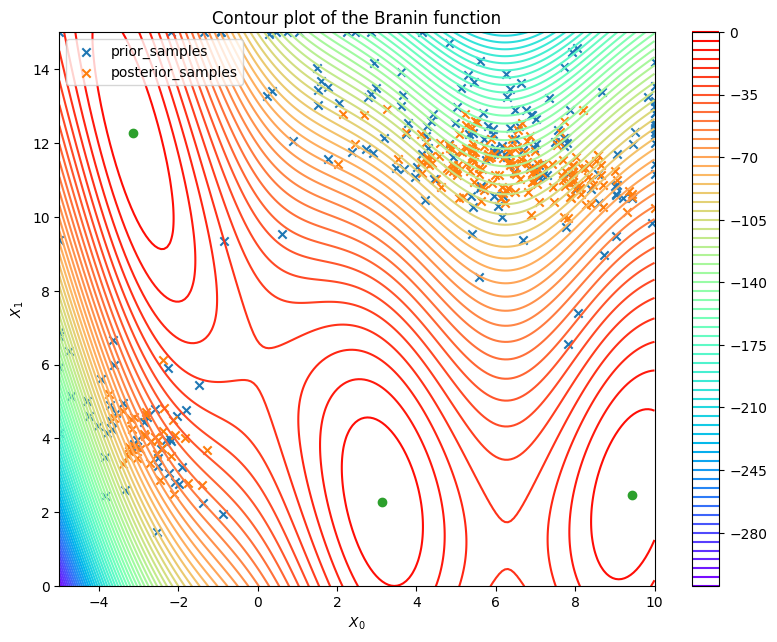

In [69]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from botorch.test_functions import Branin


# Define the Branin function using botorch
branin = Branin()
# Generate a meshgrid for the input space
x = np.linspace(-5, 10, 200)
y = np.linspace(0, 15, 200)
X, Y = np.meshgrid(x, y)

# Evaluate the Branin function on the meshgrid
Z = np.array([[branin(torch.from_numpy(np.array([X[i, j], Y[i, j]]))) for j in range(X.shape[1])] for i in range(X.shape[0])])
optima = np.array([[-np.pi, 12.275], [np.pi, 2.275], [9.42478, 2.475],])

plt.figure(figsize=(9.6, 7.2))
cp = plt.contour(X, Y, -Z, levels=75, cmap="rainbow")
plt.colorbar(cp)
#plot init_data
#plt.scatter(X_init_numpy[:, 0], X_init_numpy[:, 1], marker='x')
#plot prior samples
plt.scatter(X_sample_numpy[:, 0], X_sample_numpy[:, 1], marker='x')
#plot posterior samples
plt.scatter(X_sample_posterior_numpy[:, 0], X_sample_posterior_numpy[:, 1], marker='x')
plt.legend(['prior_samples', 'posterior_samples'])
plt.scatter(optima[:, 0], optima[:, 1], marker='o')
plt.title('Contour plot of the Branin function')
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()

In [101]:
X_sample_total = []
logR_sample_total = []
for _ in tqdm(range(1)):

    X_sample, logpf_pi, logpf_p = posterior_model.sample(bs=eval_size, device=device)
    logpf_pi = posterior_model.compute_marginal_likelihood(X_sample)
    logr = posterior_model.posterior_log_reward(X_sample).squeeze()
    logR = logr + logpf_pi * alpha
    X_sample_total.append(X_sample)
    logR_sample_total.append(logR)

    if args.local_search:
        X_sample_optimizer = torch.optim.Adam([X_sample], lr=1e-3)
        for _ in range(10000):
            X_sample.requires_grad_(True)
            logr_sample = posterior_model.posterior_log_reward(X_sample).squeeze()
            logpf_pi_sample = posterior_model.compute_marginal_likelihood(X_sample)
            logR_sample = logr_sample + logpf_pi_sample * alpha
            loss = -logR_sample.sum()
            
            X_sample_optimizer.zero_grad()
            loss.backward()
            X_sample_optimizer.step()
        X_sample = X_sample.detach()
        logR_sample = logR_sample.detach()
        
        X_sample_total.append(X_sample)
        logR_sample_total.append(logR_sample)
    

            
X_sample = torch.cat(X_sample_total, dim=0)
logR_sample = torch.cat(logR_sample_total, dim=0)

X_sample = X_sample[torch.argsort(logR_sample, descending=True)][:eval_size]
logR_sample = logR_sample[torch.argsort(logR_sample, descending=True)][:eval_size]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


In [102]:
X_sample = X_sample * (X_std + 1e-7) + X_mean
X_sample[:, 0] = torch.clamp(X_sample[:, 0], min=bounds[0][0], max=bounds[0][1])
X_sample[:, 1] = torch.clamp(X_sample[:, 1], min=bounds[1][0], max=bounds[1][1])
y_sample_ls = torch.tensor([branin(x) for x in X_sample], dtype=dtype, device=device).unsqueeze(-1)
X_sample_ls_numpy = X_sample.detach().cpu().numpy()
y_sample_ls_numpy = y_sample_ls.detach().cpu().numpy()


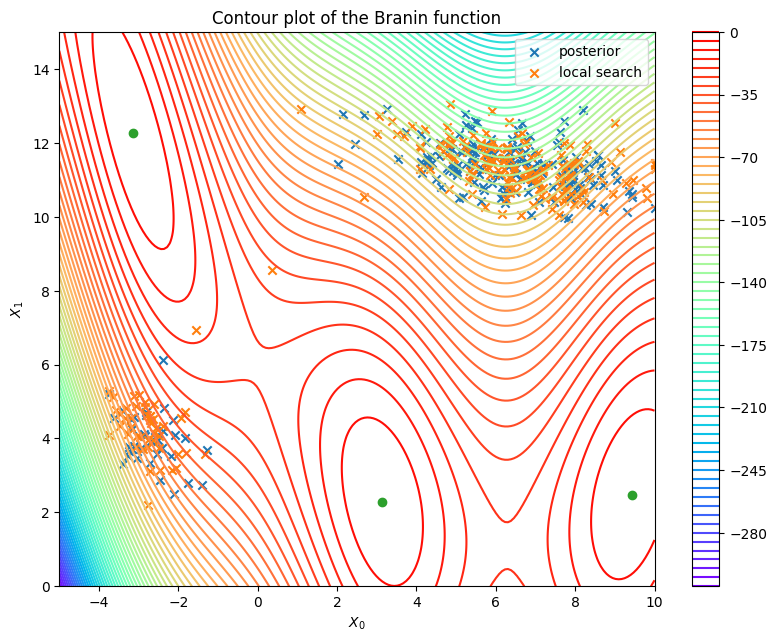

In [103]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from botorch.test_functions import Branin


# Define the Branin function using botorch
branin = Branin()
# Generate a meshgrid for the input space
x = np.linspace(-5, 10, 200)
y = np.linspace(0, 15, 200)
X, Y = np.meshgrid(x, y)

# Evaluate the Branin function on the meshgrid
Z = np.array([[branin(torch.from_numpy(np.array([X[i, j], Y[i, j]]))) for j in range(X.shape[1])] for i in range(X.shape[0])])
optima = np.array([[-np.pi, 12.275], [np.pi, 2.275], [9.42478, 2.475],])

plt.figure(figsize=(9.6, 7.2))
cp = plt.contour(X, Y, -Z, levels=75, cmap="rainbow")
plt.colorbar(cp)
#plot init_data
#plt.scatter(X_init_numpy[:, 0], X_init_numpy[:, 1], marker='x')
#plot prior samples
#plt.scatter(X_sample_numpy[:, 0], X_sample_numpy[:, 1], marker='x')
#plot posterior samples
plt.scatter(X_sample_posterior_numpy[:, 0], X_sample_posterior_numpy[:, 1], marker='x')
#plot local search samples
plt.scatter(X_sample_ls_numpy[:, 0], X_sample_ls_numpy[:, 1], marker='x')
plt.scatter(optima[:, 0], optima[:, 1], marker='o')
plt.legend(['posterior', 'local search'])
plt.title('Contour plot of the Branin function')
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()

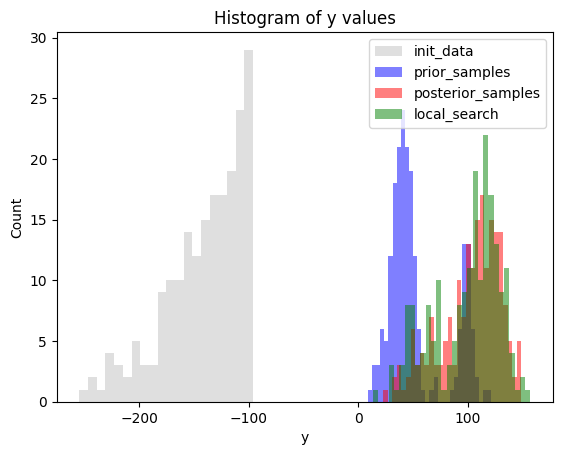

In [104]:
plt.hist(y_init_numpy, bins=20, alpha=0.5, label='init_data', color='silver')
plt.hist(y_sample_numpy, bins=30, alpha=0.5, label='prior_samples', color='blue')
plt.hist(y_sample_posterior_numpy, bins=30, alpha=0.5, label='posterior_samples', color='red')
plt.hist(y_sample_ls_numpy, bins=30, alpha=0.5, label='local_search', color='green')
plt.legend()
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Histogram of y values')
plt.show()